#### PSD e IIA

# QRS detector
#### Francisco Maiocchi

***
### Introducción

Este notebook prueba distintos tipos de arquitectura de red para la detección de latidos en un ECG. El paquete de Python llamado WFDB (https://github.com/MIT-LCP/wfdb-python) da acceso a los datasets de https://physionet.org/physiobank/database/#ecg. En este ejemplo se utiliza la base de datos MIT-BIH Arrhythmia.  

Esta base de datos cuenta con 48 registros de ECG de dos canales cada uno. Cada registro consta de tres archivos que brindan distinto tipo de información. Esto hace un total de 62400000 muestras de ECG con una frecuencia de muestreo de 360 Hz

Siguiendo los pasos de https://medium.com/@roszcz/machine-learning-for-medicine-qrs-detection-in-a-single-channel-ecg-signal-part-1-data-set-be36f70bbd38 se pasaron todas las anotaciones de latidos (originalmente deltas) a campanas de gauss que se pueden interpretar como la densidad de probabilidad. Esto se debe a que las anotaciones de esta base de datos no son del todo uniformes (algunas estan levemente desplazadas).  

Por otro lado, para alimentar las redes, se dividió cada registro en ventanas de un ancho fijo por lo que cada ejemplo es un array de tamaño fijo. Por el momento, las ventanas no se solapan. En un futuro se puede analizar el solapamiento de ventanas como una técnica de data augmentation. Hay muchas base de datos de ECG en el enlace mencionado anteriormente, por lo que más adelante se pueden agregar más datos.  

Por otro lado, los datasets se normalizaron. A cada ejemplo de entrada se le restó el valor medio y se lo dividió por el desvío estandard tal cual propone el paper _Deep learning based QRS Multilead Delineator in Electrocardiogram signals_. Los labels fueron normalizados para que su area sea unitaria.


***
### Imports

In [136]:
# Importo TensorFlow como tf
import tensorflow as tf
# Importo keras
from tensorflow import keras

# Librerias auxiliares
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from IPython.display import HTML
import os
from glob import glob
import urllib3
import pandas as pd
from bs4 import BeautifulSoup as BSoup
import h5py
import wfdb as wf
from scipy import signal as ss

print(tf.__version__)


1.12.0


### Definiciones

+ width: es el ancho de la ventana

In [137]:
WIDTH = 200

### Funciones utilizadas

In [138]:
def download_db():
    
    extensions = ['atr', 'dat', 'hea']
    the_path = 'https://www.physionet.org/physiobank/database/mitdb/'
    
    # Guardo en data/
    savedir = 'data/mitdb'
    if not os.path.exists(savedir):
        os.makedirs(savedir)

    # Formato de guardado
    savename = savedir + '/{}.{}'

    # Encuentro todos los archivos importantes del sitio
    http = urllib3.PoolManager()
    response = http.request('GET', the_path)
    soup = BSoup(response.data)

    # Encuentro todos los links a archivos .dat 
    hrefs = []
    for a in soup.find_all('a', href=True):
        href = a['href']
        # Descargo los archivos con los marcadores dados
        if href[-4::] == '.dat':
            hrefs.append(href[:-4])
        
    # Path al archivo en internet
    down_path = the_path + '{}.{}'

    for data_id in hrefs:
        for ext in extensions:
            webpath = down_path.format(data_id, ext)
            http = urllib3.PoolManager()
            datafile = http.request('GET', webpath)

            # Guardo localmente
            filepath = savename.format(data_id, ext)
            with open(filepath, 'wb') as out:
                out.write(datafile.data)
    
    print ('Se descargaron ' + str(len(hrefs)) + ' archivos de datos')

def get_records():

    # Descargo si no existe
    if not os.path.isdir('data/mitdb'):
        print ('Descargando mitdb ecg database...')
        download_db()
        print ('Descarga terminada')
        
    # Hay 3 archivos por record
    # *.atr es uno de ellos
    paths = glob('data/mitdb/*.atr')

    # Elimino la extensión
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

def get_beats(annotation):

    types = np.array(annotation.symbol)
    
    beat_symbols = ['N', 'L', 'R', 'B', 'A',
        'a', 'J', 'S', 'V', 'r',
        'F', 'e', 'j', 'n', 'E',
        '/', 'f', 'Q', '?']
    
    ids = np.in1d(annotation.symbol, beat_symbols)

    # Me quedo con las posiciones
    beats = annotation.sample[ids]

    return beats


def get_normal_beats(annotation):
    
    types = np.array(annotation.symbol)
    where = np.where((types == 'N'))
    
    normal_beats = annotation.sample[where]
    
    return normal_beats

def convert_input(channel, beats):
    # Me quedo con todo los latidos

    # Creo una señal con deltas en los latidos
    dirac = np.zeros_like(channel)
    dirac[beats] = 1.0

    # Uso la ventana de hamming para la campana
    width = 36
    filter = ss.hamming(width)
    gauss = np.convolve(filter, dirac, mode = 'same')

    return dirac, gauss

def make_dataset(records, width, savepath):

    signals, labels = [], []

    # Recorro los archivos
    for path in records:
        print ('Processing file:' + path)
        data, field = wf.rdsamp(path)
        annotations = wf.rdann(path, 'atr')

        # Convierto cada canal en datos y labels
        signal, label = convert_data(data, annotations, width)

        # Acumulo
        signals.append(signal)
        labels.append(label)

    # Convierto todo en un np.array
    signals = np.vstack(signals)
    labels = np.vstack(labels)
    
    # En este caso descarto los deltas. ¡VER QUE PASA SI ENTRENAMOS CON LOS DELTA!
    labels = labels[:, 1, :]

    # Guardo en forma de diccionario
    np.save(savepath, {'signals' : signals,
                       'labels'  : labels })

def convert_data(data, annotations, width):
    
    signals, labels = [], []
    
    beats = get_beats(annotations)

    # Convierto ambos canales
    for it in range(2):
        channel = data[:, it]
        dirac, gauss = convert_input(channel, beats)
        # Junto los labesl
        label = np.vstack([dirac, gauss])

        # Ventana movil
        sta = 0
        end = width
        stride = width
        while end <= len(channel):
            # Me quedo con una ventana
            s_frag = channel[sta : end]
            l_frag = label[:, sta : end]

            # Acumulo
            signals.append(s_frag)
            labels.append(l_frag)

            # Paso a la ventana siguiente
            sta += stride
            end += stride

    # Convierto a np.array
    signals = np.array(signals)
    labels = np.array(labels)

    return signals, labels

def create_datasets():

    # Preparo los archivos
    records = get_records()

    # Mezclo los archivos
    np.random.seed(666)
    np.random.shuffle(records)

    # Tamaño de la ventana
    width = WIDTH

    # Armo el set de entrenamiento
    make_dataset(records[:30], width, 'data/training')

    # Armo el set de validacion
    make_dataset(records[30 : 39], width, 'data/validation')

    # Armo el set de testeo
    make_dataset(records[39 : 48], width, 'data/test')

### Creación del dataset 

Este paso es opcional, si ya existe un dataset, se puede arrancar el notebook en **Cargar datasets**

In [139]:
create_datasets()

Processing file:data/mitdb\220
Processing file:data/mitdb\228
Processing file:data/mitdb\233
Processing file:data/mitdb\219
Processing file:data/mitdb\201
Processing file:data/mitdb\103
Processing file:data/mitdb\108
Processing file:data/mitdb\230
Processing file:data/mitdb\100
Processing file:data/mitdb\101
Processing file:data/mitdb\107
Processing file:data/mitdb\118
Processing file:data/mitdb\221
Processing file:data/mitdb\111
Processing file:data/mitdb\121
Processing file:data/mitdb\222
Processing file:data/mitdb\200
Processing file:data/mitdb\208
Processing file:data/mitdb\215
Processing file:data/mitdb\124
Processing file:data/mitdb\203
Processing file:data/mitdb\214
Processing file:data/mitdb\104
Processing file:data/mitdb\202
Processing file:data/mitdb\112
Processing file:data/mitdb\122
Processing file:data/mitdb\123
Processing file:data/mitdb\212
Processing file:data/mitdb\114
Processing file:data/mitdb\116
Processing file:data/mitdb\113
Processing file:data/mitdb\119
Processi

### Cargar datasets

In [140]:
# Cargo el set de entrenamiento
train_path = 'data/training.npy'
training_set = np.load(train_path)[()]

# Normalizo los datos de entrenamiento
train_input = training_set.get('signals')
train_input_norm = (train_input - np.mean(train_input, axis = 1,  keepdims = True)) / (np.std(train_input, axis = 1,  keepdims = True) + np.finfo(float).eps)

# Normalizo las labels de entrenamiento
train_label = training_set.get('labels')
train_label = (train_label - np.min(train_label, axis = 1, keepdims = True)) / (np.max(train_label, axis = 1, keepdims = True) - np.min(train_label, axis = 1, keepdims = True) + np.finfo(float).eps)
train_label_norm = train_label / (np.sum(train_label, axis = 1, keepdims = True) + np.finfo(float).eps)

# Cargo el set de validación
validation_path = 'data/validation.npy'
validation_set = np.load(validation_path)[()]

# Normalizo los datos de validación
validation_input = validation_set.get('signals')
validation_input_norm = (validation_input - np.mean(validation_input, axis = 1,  keepdims = True)) / (np.std(validation_input, axis = 1,  keepdims = True) + np.finfo(float).eps)

# Normalizo las labels de validación
validation_label = validation_set.get('labels')
validation_label = (validation_label - np.min(validation_label, axis = 1, keepdims = True)) / (np.max(validation_label, axis = 1, keepdims = True) - np.min(validation_label, axis = 1, keepdims = True) + np.finfo(float).eps)
validation_label_norm = validation_label / (np.sum(validation_label, axis = 1, keepdims = True) + np.finfo(float).eps)

# Cargo el set de test
test_path = 'data/test.npy'
test_set = np.load(test_path)[()]

# Normalizo los datos de testeo
test_input = test_set.get('signals')
test_input_norm = (test_input - np.mean(test_input, axis = 1,  keepdims = True)) / (np.std(test_input, axis = 1,  keepdims = True) + np.finfo(float).eps)

# Normalizo las labels de testeo
test_label = test_set.get('labels')
test_label = (test_label - np.min(test_label, axis = 1, keepdims = True)) / (np.max(test_label, axis = 1, keepdims = True) - np.min(test_label, axis = 1, keepdims = True) + np.finfo(float).eps)
test_label_norm = test_label / (np.sum(test_label, axis = 1, keepdims = True) + np.finfo(float).eps)

# Definiciones para más adelante
examples = np.random.randint(np.size(test_input,0), size = 5) # Se utiliza para sacar 5 ejemplos al azar del set de entrenamiento

***
### ConvNet 1

##### Arquitectura

Esta red cuenta con tres capas:

+ Capa fully-connected de 200 neuronas con activación ReLU (Rectified Linear Unit).
+ Capa fully-connected de 200 neuronas con activación ReLU (Rectified Linear Unit).
+ Capa fully-connected de 200 neuronas con activación sigmoid.

In [141]:
model = keras.Sequential()
model.add(keras.layers.Dense(200, activation = tf.nn.relu))
model.add(keras.layers.Dense(200, activation = tf.nn.relu))
model.add(keras.layers.Dense(200, activation = tf.nn.sigmoid))

##### Configuración de red

Este modelo usa el optimizador Adam. Su loss function es el error cuadrático medio y la métrica es el error absoluto medio.

In [142]:
model.compile(optimizer = tf.train.AdamOptimizer(0.01),
              loss = 'mse',       # mean squared error
              metrics = ['mae'])  # mean absolute error

##### Entrenamiento

Se entrena por 20 épocas y se implementa un callback para que se frene el entrenamiento en caso de que la pérdida por validación no mejore en 4 épocas.

In [143]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 4)

history = model.fit(train_input_norm,
                    train_label_norm,
                    epochs = 20,
                    validation_data = (validation_input_norm, validation_label_norm),
                    callbacks=[early_stop])

Train on 195000 samples, validate on 58500 samples
Epoch 1/20
195000/195000 [==============================] - 15s 77us/step - loss: 3.0296e-04 - mean_absolute_error: 0.0041 - val_loss: 2.4099e-04 - val_mean_absolute_error: 0.0039
Epoch 2/20
195000/195000 [==============================] - 15s 76us/step - loss: 2.4581e-04 - mean_absolute_error: 0.0040 - val_loss: 2.4099e-04 - val_mean_absolute_error: 0.0039
Epoch 3/20
195000/195000 [==============================] - 15s 74us/step - loss: 2.4581e-04 - mean_absolute_error: 0.0040 - val_loss: 2.4099e-04 - val_mean_absolute_error: 0.0039
Epoch 4/20
195000/195000 [==============================] - 14s 74us/step - loss: 2.4581e-04 - mean_absolute_error: 0.0040 - val_loss: 2.4099e-04 - val_mean_absolute_error: 0.0039
Epoch 5/20
195000/195000 [==============================] - 15s 75us/step - loss: 2.4581e-04 - mean_absolute_error: 0.0040 - val_loss: 2.4099e-04 - val_mean_absolute_error: 0.0039


##### Evaluación del modelo

Vamos a medir el desempeño de este modelo con el set de testeo

In [144]:
test_loss_1, test_mae_1 = model.evaluate(test_input_norm, test_label_norm)

print('El error absoluto medio es de ' + str(test_mae_1))

58500/58500 [==============================] - 2s 30us/step
El error absoluto medio es de 0.004069744147615045


Vamos a predecir y gráficar algunos ejemplos del set de testeo para comparar la salida de la red con el resultado esperado.

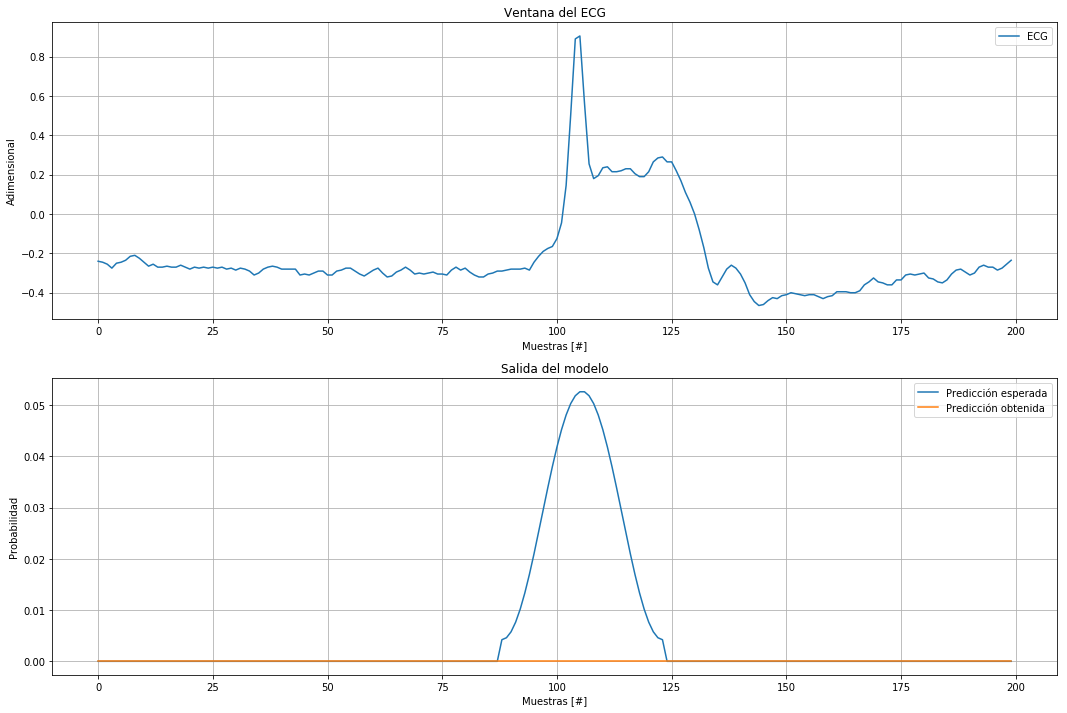

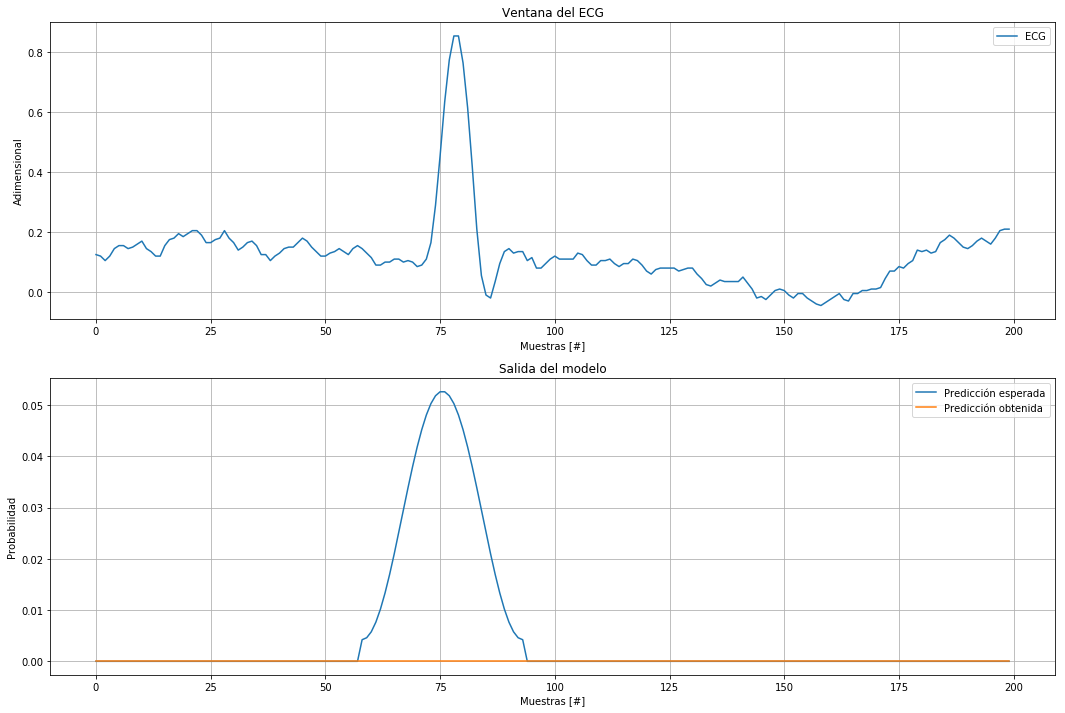

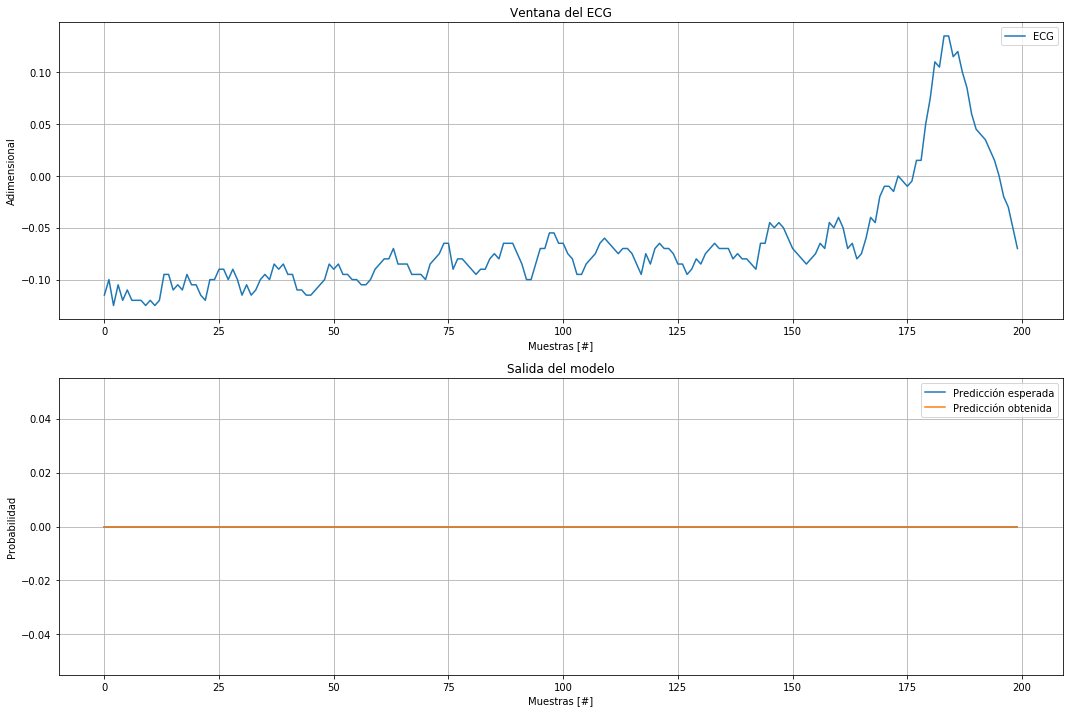

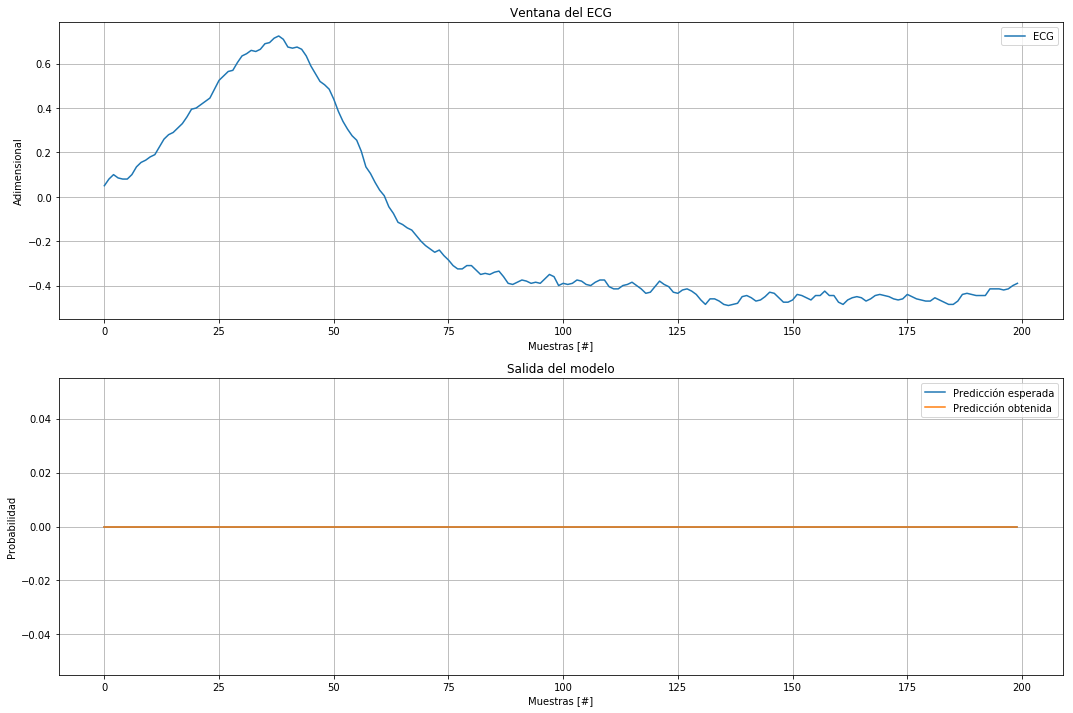

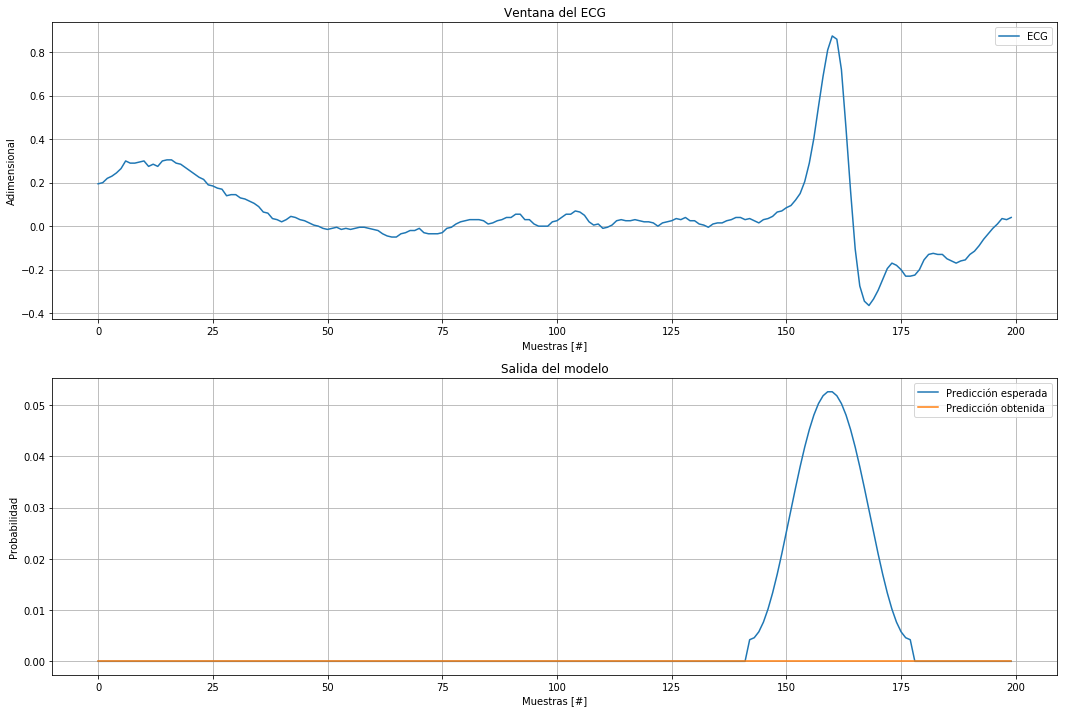

In [145]:
predictions = model.predict(test_input_norm)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label_norm[i], label = 'Predicción esperada')
    plt.plot(predictions[i], label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()

##### Análisis de entrenamiento

Vemos como evolucionan las métricas y la loss function a lo largo del entrenamiento.

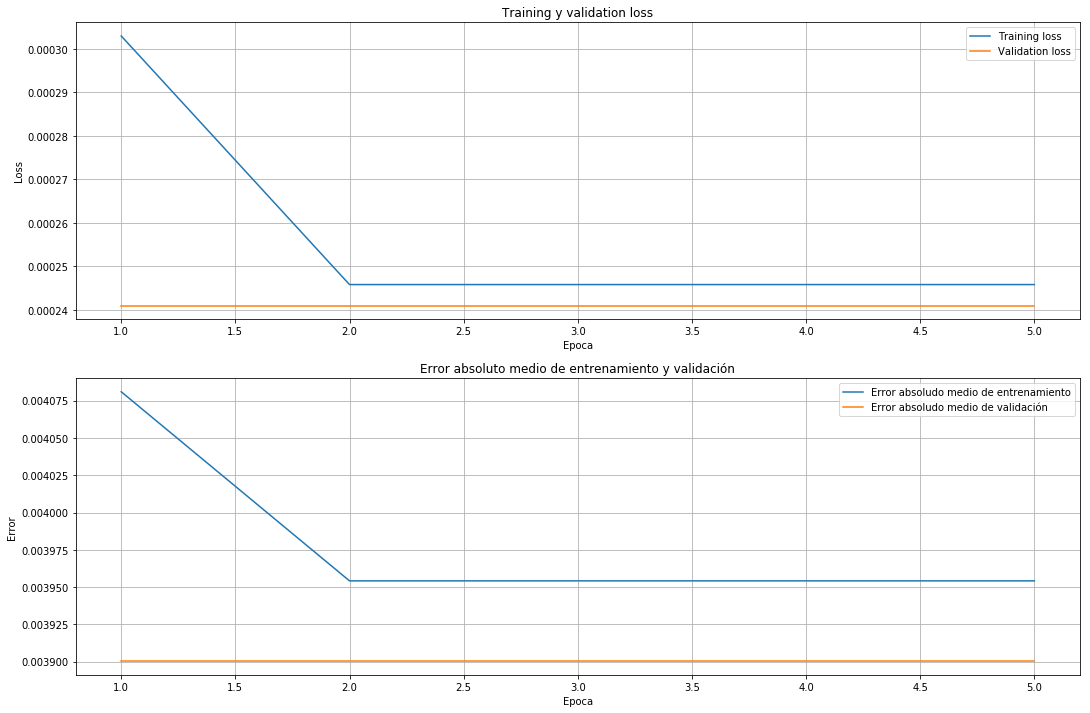

In [146]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

##### Conclusión

Esta arquitectura no tiene resultados satisfactorios. Probablemente es por la función activación de la capa de salida.

***
### ConvNet 2

##### Arquitectura

La única diferencia con la red anterior es la función activación de la última capa. En este caso, se usa la función softmax.

Esta red cuenta con tres capas:

+ Capa fully-connected de 200 neuronas con activación ReLU (Rectified Linear Unit).
+ Capa fully-connected de 200 neuronas con activación ReLU (Rectified Linear Unit).
+ Capa fully-connected de 200 neuronas con activación softmax.

In [147]:
model = keras.Sequential()
model.add(keras.layers.Dense(200, activation = tf.nn.relu))
model.add(keras.layers.Dense(200, activation = tf.nn.relu))
model.add(keras.layers.Dense(200, activation = tf.nn.softmax))

##### Configuración de red

Este modelo usa el optimizador Adam. Su loss function es el error cuadrático medio y la métrica es el error absoluto medio.  

Esto es igual que la red anterior.

In [148]:
model.compile(optimizer=tf.train.AdamOptimizer(0.01),
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error

##### Entrenamiento

Se entrena por 20 épocas y se implementa un callback para que se frene el entrenamiento en caso de que la pérdida por validación no mejore en 4 épocas.

In [149]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 4)

history = model.fit(train_input_norm,
                    train_label_norm,
                    epochs = 20,
                    validation_data = (validation_input_norm, validation_label_norm),
                    callbacks=[early_stop])

Train on 195000 samples, validate on 58500 samples
Epoch 1/20
195000/195000 [==============================] - 17s 85us/step - loss: 1.5484e-04 - mean_absolute_error: 0.0045 - val_loss: 1.3777e-04 - val_mean_absolute_error: 0.0040
Epoch 2/20
195000/195000 [==============================] - 17s 85us/step - loss: 1.3613e-04 - mean_absolute_error: 0.0040 - val_loss: 1.3528e-04 - val_mean_absolute_error: 0.0039
Epoch 3/20
195000/195000 [==============================] - 17s 88us/step - loss: 1.3119e-04 - mean_absolute_error: 0.0039 - val_loss: 1.2438e-04 - val_mean_absolute_error: 0.0037
Epoch 4/20
195000/195000 [==============================] - 15s 77us/step - loss: 1.2828e-04 - mean_absolute_error: 0.0038 - val_loss: 1.2733e-04 - val_mean_absolute_error: 0.0037
Epoch 5/20
195000/195000 [==============================] - 15s 78us/step - loss: 1.2652e-04 - mean_absolute_error: 0.0038 - val_loss: 1.2875e-04 - val_mean_absolute_error: 0.0038
Epoch 6/20
195000/195000 [=======================

##### Evaluación del modelo

Vamos a medir el desempeño de este modelo con el set de testeo

In [150]:
test_loss_2, test_mae_2 = model.evaluate(test_input_norm, test_label_norm)

print('El error absoluto medio es de ' + str(test_mae_2))

58500/58500 [==============================] - 2s 32us/step
El error absoluto medio es de 0.003866364495112346


Vamos a predecir y gráficar algunos ejemplos del set de testeo para comparar la salida de la red con el resultado esperado.

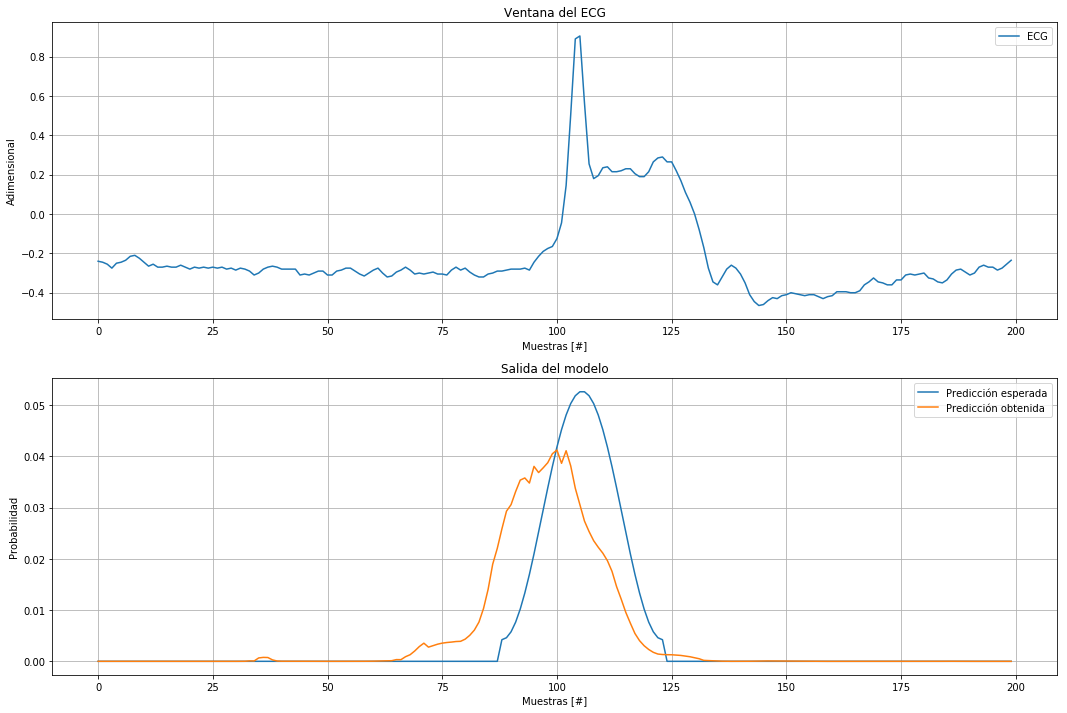

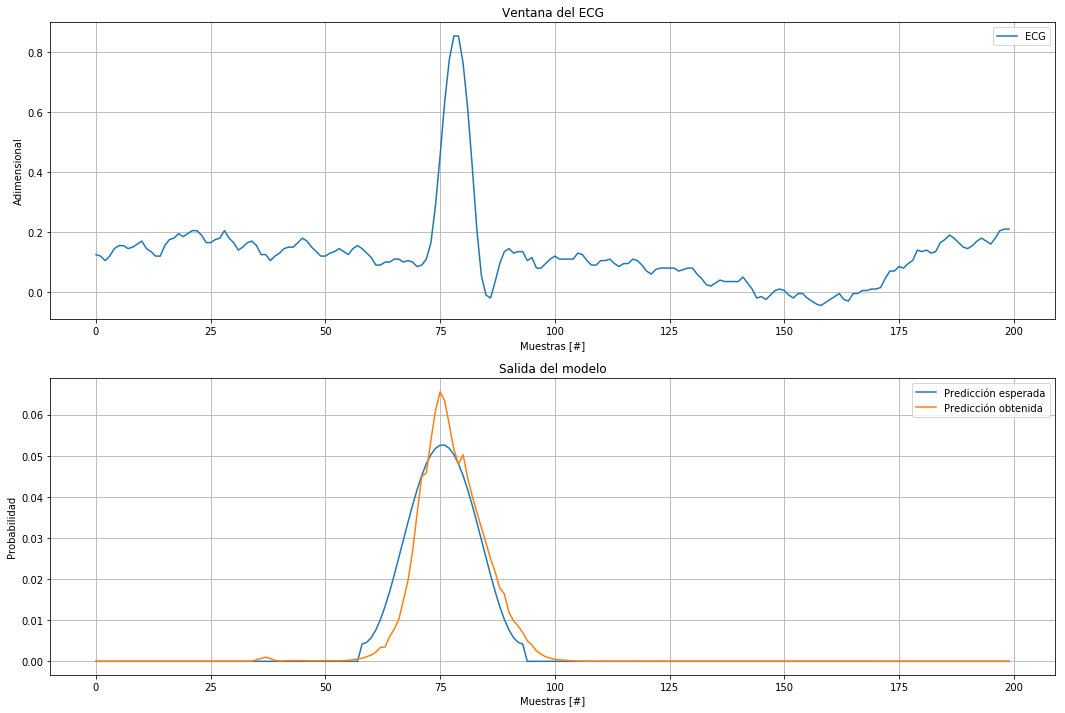

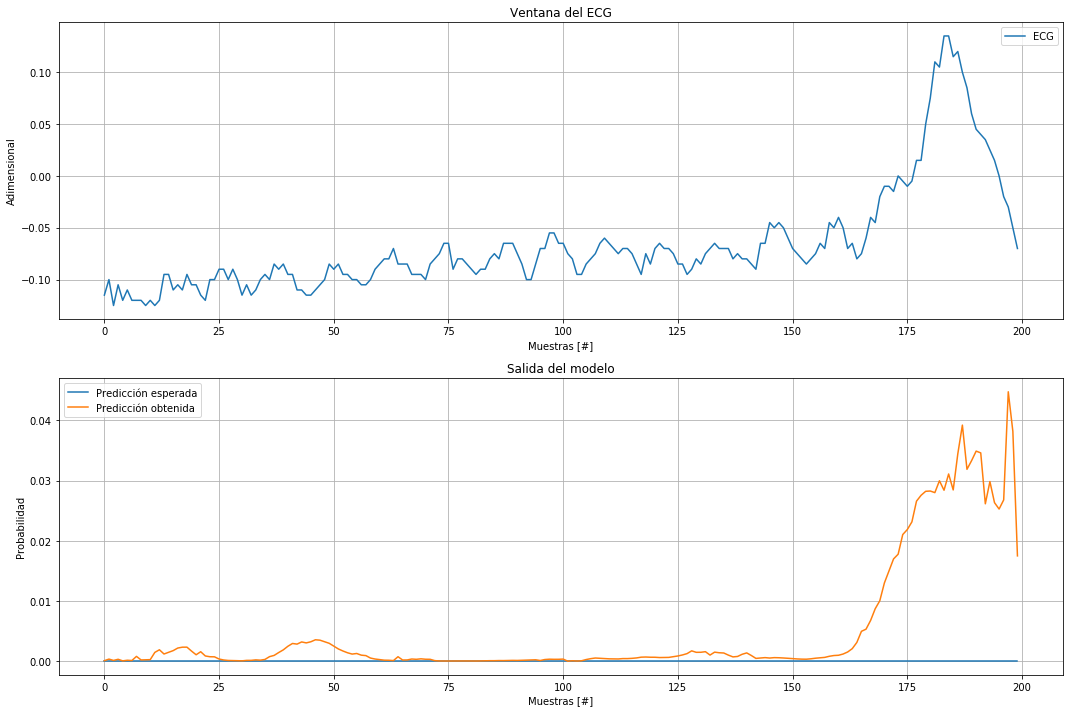

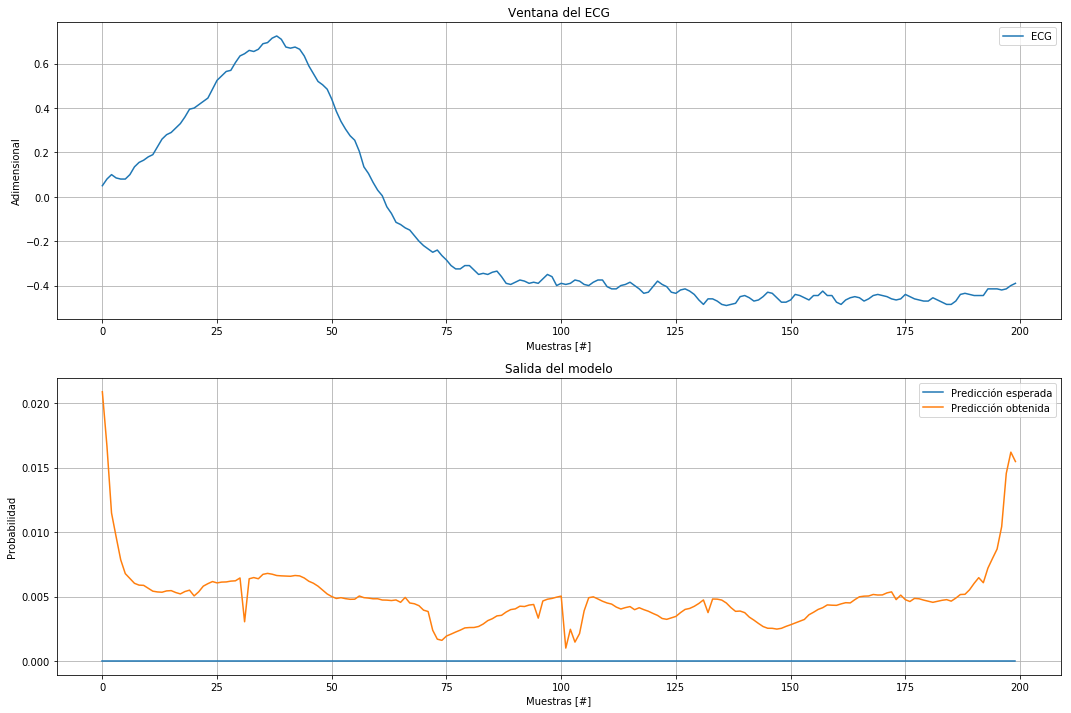

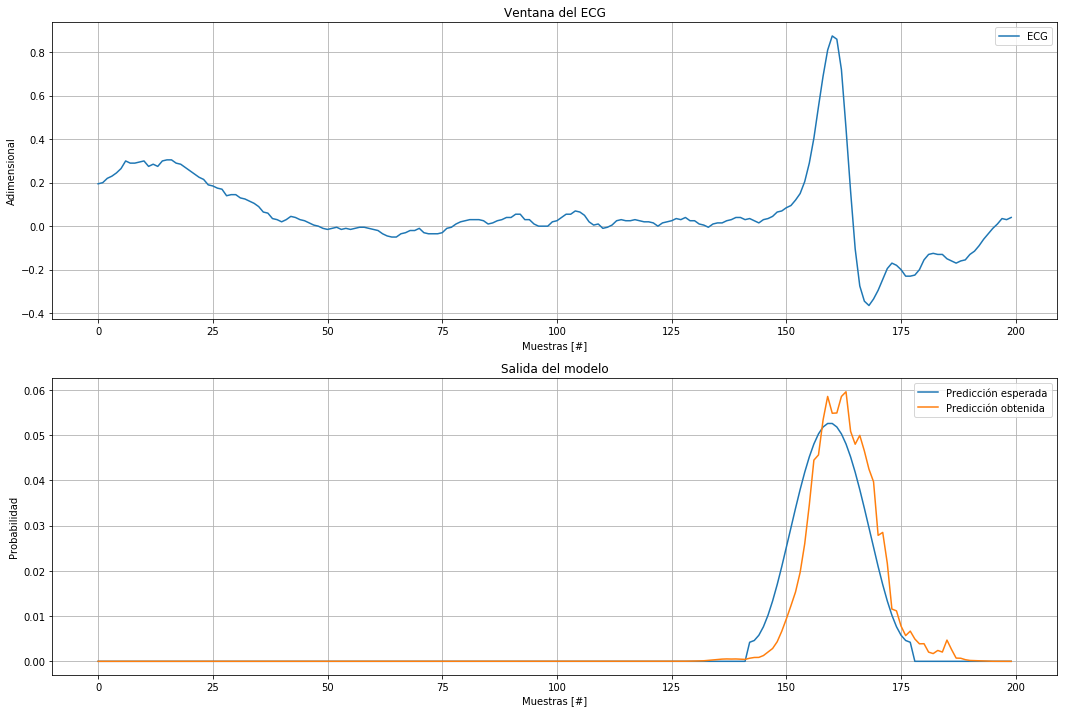

In [151]:
predictions = model.predict(test_input_norm)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label_norm[i], label = 'Predicción esperada')
    plt.plot(predictions[i], label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()

##### Análisis de entrenamiento

Vemos como evolucionan las métricas y la loss function a lo largo del entrenamiento.

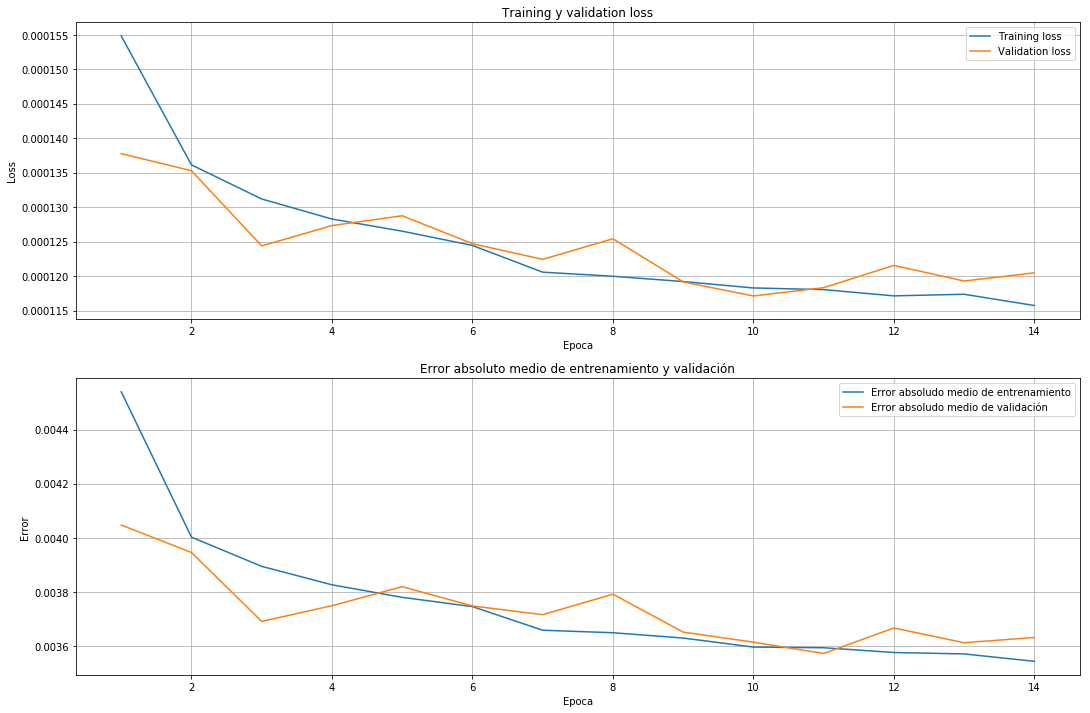

In [152]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

##### Conclusión

Esta arquitectura tiene una mejora notable respecto a la anterior. Si bien las predicciones no tienen forma de campana de gauss como las labels, su forma y centro se parece.

***
### ConvNet 3

##### Arquitectura

La única diferencia con la ConvNet 2 es que la tasa de aprendizaje del optimizador Adam pasa de 0.01 a 0.001

Esta red cuenta con tres capas:

+ Capa fully-connected de 200 neuronas con activación ReLU (Rectified Linear Unit).
+ Capa fully-connected de 200 neuronas con activación ReLU (Rectified Linear Unit).
+ Capa fully-connected de 200 neuronas con activación softmax.

In [153]:
model = keras.Sequential()
model.add(keras.layers.Dense(200, activation = tf.nn.relu))
model.add(keras.layers.Dense(200, activation = tf.nn.relu))
model.add(keras.layers.Dense(200, activation = tf.nn.softmax))

##### Configuración de red

Este modelo usa el optimizador Adam con tasa de aprendizaje de 0.001. Su loss function es el error cuadrático medio y la métrica es el error absoluto medio.

In [154]:
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='mse',       # mean squared error
              metrics=['mae'])  # mean absolute error

##### Entrenamiento

Se entrena por 20 épocas y se implementa un callback para que se frene el entrenamiento en caso de que la pérdida por validación no mejore en 4 épocas.

In [155]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 4)

history = model.fit(train_input_norm,
                    train_label_norm,
                    epochs = 20,
                    validation_data = (validation_input_norm, validation_label_norm),
                    callbacks=[early_stop])

Train on 195000 samples, validate on 58500 samples
Epoch 1/20
195000/195000 [==============================] - 16s 84us/step - loss: 1.0848e-04 - mean_absolute_error: 0.0034 - val_loss: 1.0734e-04 - val_mean_absolute_error: 0.0032
Epoch 2/20
195000/195000 [==============================] - 16s 82us/step - loss: 9.2389e-05 - mean_absolute_error: 0.0029 - val_loss: 1.0520e-04 - val_mean_absolute_error: 0.0031
Epoch 3/20
195000/195000 [==============================] - 16s 80us/step - loss: 8.7016e-05 - mean_absolute_error: 0.0028 - val_loss: 1.0281e-04 - val_mean_absolute_error: 0.0031
Epoch 4/20
195000/195000 [==============================] - 17s 87us/step - loss: 8.3811e-05 - mean_absolute_error: 0.0027 - val_loss: 1.0181e-04 - val_mean_absolute_error: 0.0031
Epoch 5/20
195000/195000 [==============================] - 16s 82us/step - loss: 8.1575e-05 - mean_absolute_error: 0.0027 - val_loss: 1.0217e-04 - val_mean_absolute_error: 0.0031
Epoch 6/20
195000/195000 [=======================

##### Evaluación del modelo

Vamos a medir el desempeño de este modelo con el set de testeo.

In [156]:
test_loss_3, test_mae_3 = model.evaluate(test_input_norm, test_label_norm)

print('El error absoluto medio es de ' + str(test_mae_3))

58500/58500 [==============================] - 2s 34us/step
El error absoluto medio es de 0.0031171990406627837


Vamos a predecir y gráficar algunos ejemplos del set de testeo para comparar la salida de la red con el resultado esperado.

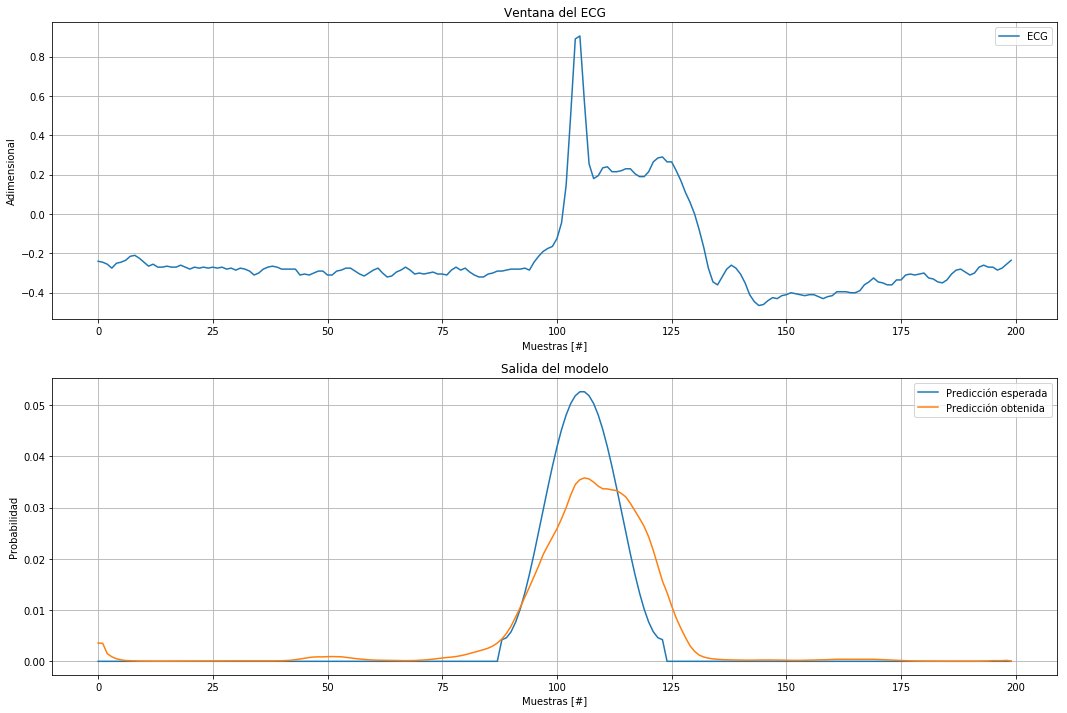

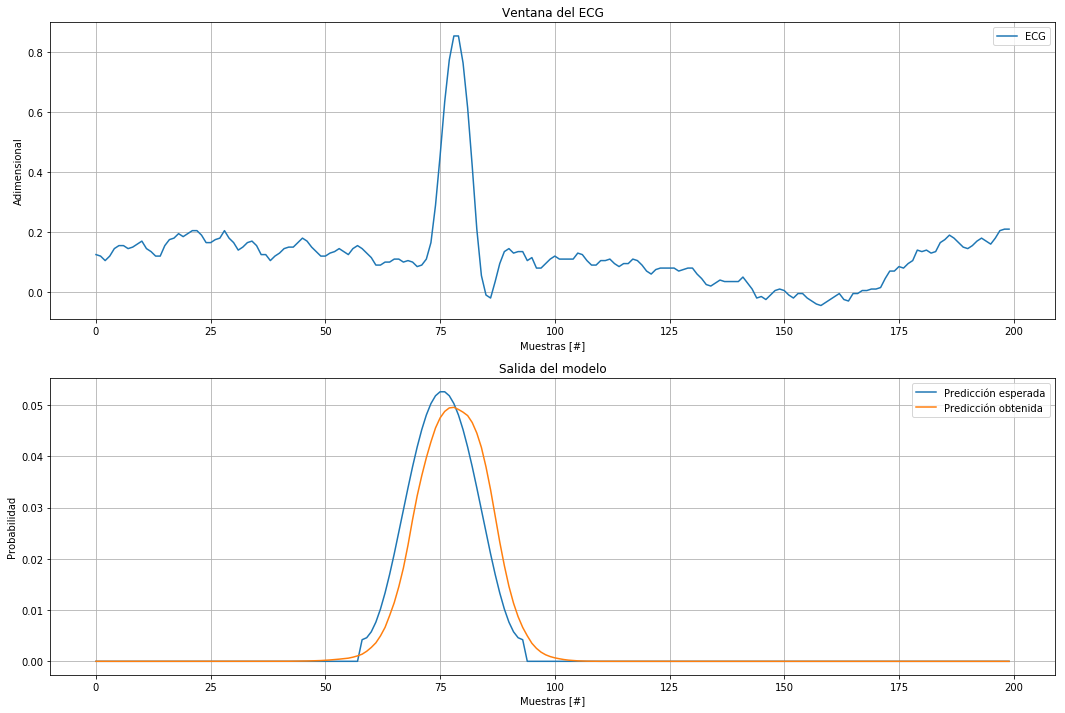

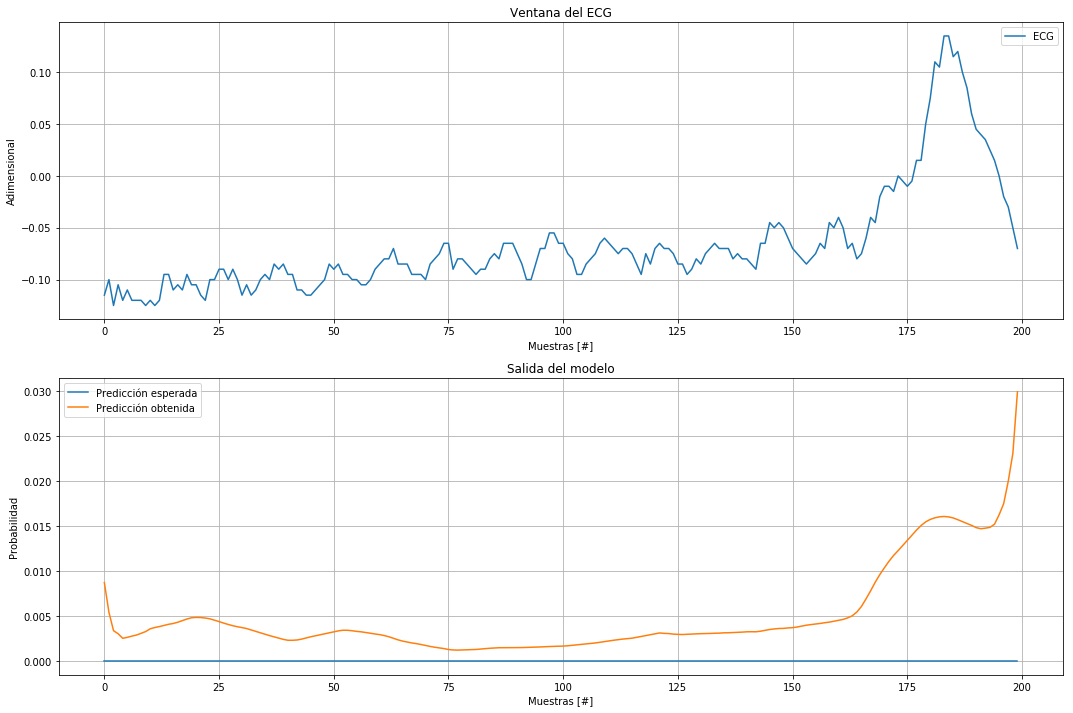

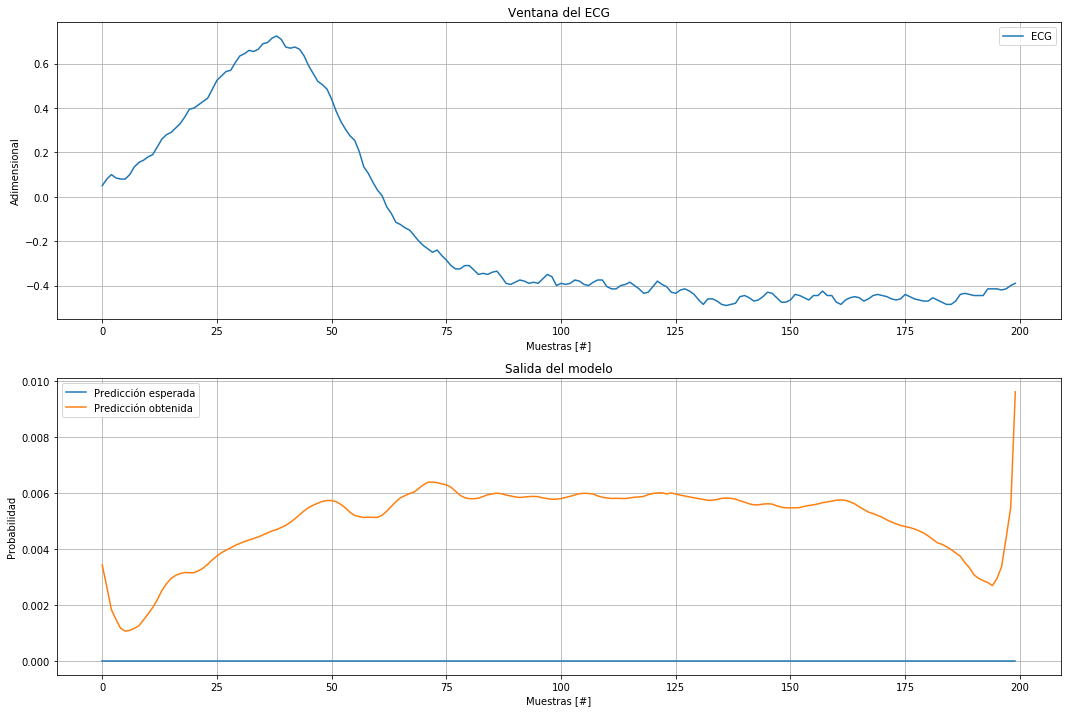

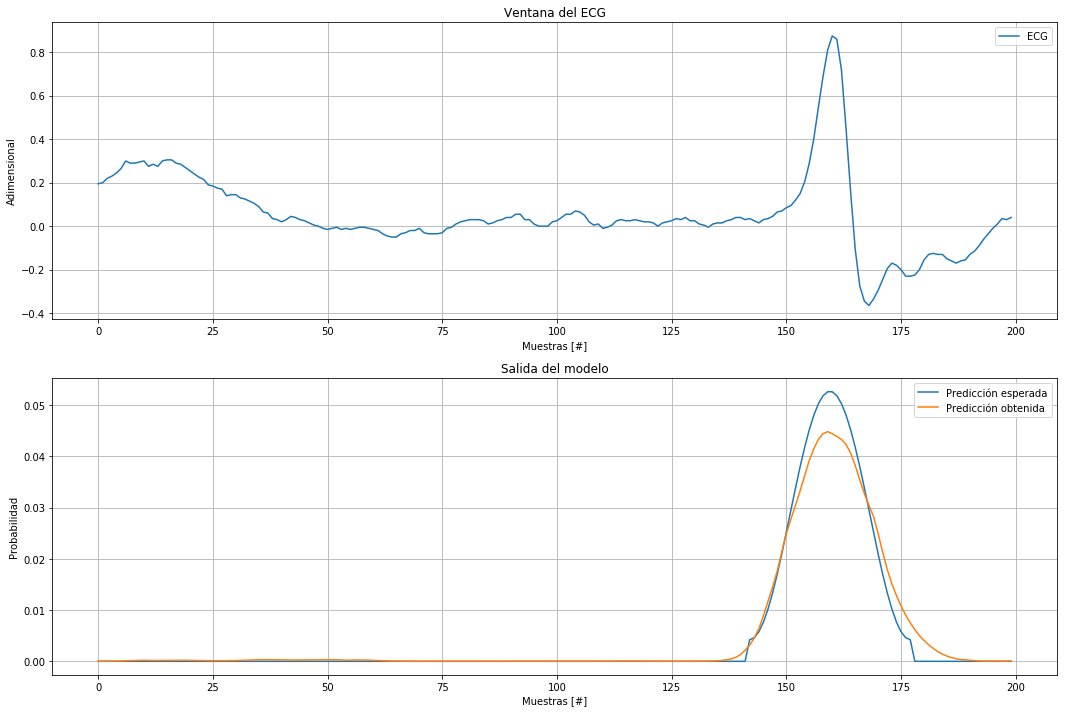

In [157]:
predictions = model.predict(test_input_norm)

for i in examples:
    
    plt.figure(figsize=(18,12))
    plt.subplot(2,1,1)
    plt.plot(test_input[i], label = 'ECG')
    plt.title('Ventana del ECG')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Adimensional')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(test_label_norm[i], label = 'Predicción esperada')
    plt.plot(predictions[i], label = 'Predicción obtenida')
    plt.title('Salida del modelo')
    plt.xlabel('Muestras [#]')
    plt.ylabel('Probabilidad')
    plt.grid()
    plt.legend()

##### Análisis de entrenamiento

Vemos como evolucionan las métricas y la loss function a lo largo del entrenamiento.

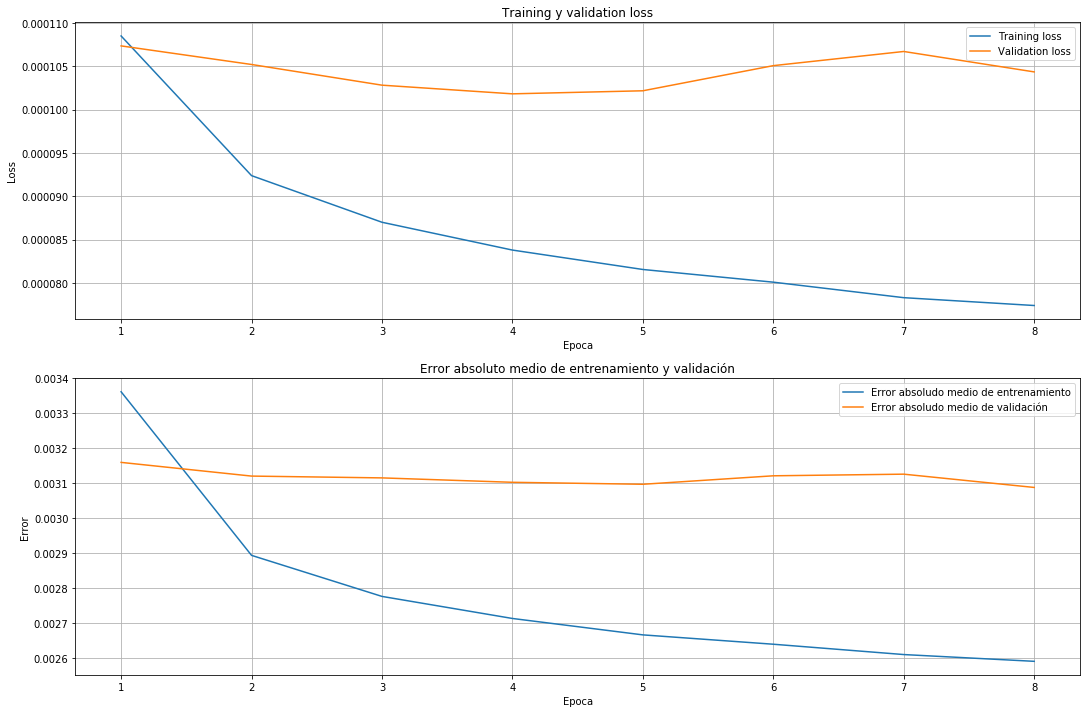

In [158]:
epochs = range(1, len(history.history['mean_absolute_error']) + 1)

plt.figure(figsize=(18,12))

plt.subplot(2,1,1)


plt.plot(epochs, history.history['loss'], label = 'Training loss')
plt.plot(epochs, history.history['val_loss'], label = 'Validation loss')
plt.title('Training y validation loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(2,1,2)

plt.plot(epochs, history.history['mean_absolute_error'], label = 'Error absoludo medio de entrenamiento')
plt.plot(epochs, history.history['val_mean_absolute_error'], label = 'Error absoludo medio de validación')
plt.title('Error absoluto medio de entrenamiento y validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid()
plt.legend()

##### Conclusión

Las predicciones de este modelo se asemejan mejor en forma a las labels, pero su centro esta desplazado.

### Comparación de desempeño

In [159]:
tus_resultados = [ 
                   [test_loss_1, test_mae_1],
                   [test_loss_2, test_mae_2], 
                   [test_loss_3, test_mae_3],
                 ]
df = DataFrame(tus_resultados, columns=['Test loss', 'Test mae'],
               index=["ConvNet 1","ConvNet 2","ConvNet 3"])
HTML(df.to_html())

,Test loss,Test mae
ConvNet 1,0.000259,0.004070
ConvNet 2,0.000141,0.003866
ConvNet 3,0.000124,0.003117
